In [14]:
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
import getdist.mcsamples as gmc
import numpy as np
import pyccl as ccl
import pyhmcode
import pyhmcode.halo_profile_utils
from scipy.interpolate import interp1d

In [15]:
def get_bin_z(ibin):
    fnames = ['nz_2MPZ.npz',
              'nz_WIxSC_binz0p10_0p15.npz',
              'nz_WIxSC_binz0p15_0p20.npz',
              'nz_WIxSC_binz0p20_0p25.npz',
              'nz_WIxSC_binz0p25_0p30.npz',
              'nz_WIxSC_binz0p30_0p35.npz']
    fname = '/home/damonge/Science/CurrentProjects/2019_yxgxk/xCell/data_yxgxk/' + fnames[ibin]
    d = np.load(fname)
    z_mean = np.average(d['z_mid'], weights=d['nz'])
    z_std = np.sqrt(np.average((d['z_mid']-z_mean)**2, weights=d['nz']))
    return z_mean, z_std
for i in range(6):
    print(get_bin_z(i))

(0.06407827174103713, 0.02586427168577907)
(0.13496553347429308, 0.060013910528447456)
(0.18685372335794864, 0.06290049576177939)
(0.2364611382540309, 0.06863886132393521)
(0.286332995683299, 0.07050023811421773)
(0.3401450561296044, 0.06657278053132519)


In [16]:
cosmo_global = ccl.Cosmology(Omega_c=0.26066676,
                             Omega_b=0.048974682,
                             h=0.6766,
                             n_s=0.9665,
                             sigma8=0.8102)
print(ccl.sigma8(cosmo_global))

0.8101999999999999


In [17]:
class ArnaudCalculator(object):
    def __init__(self):
        self.cosmo = cosmo_global
        self.massdef = ccl.halos.MassDef(500, 'critical')
        self.prof = ccl.halos.HaloProfilePressureGNFW()
        self.prof.update_parameters(mass_bias=0.8)
        mfc = ccl.halos.mass_function_from_name('Tinker08')
        mf = mfc(self.cosmo, mass_def=self.massdef)
        hbc = ccl.halos.halo_bias_from_name('Tinker10')
        hb = hbc(self.cosmo, mass_def=self.massdef)
        self.hmc = ccl.halos.HMCalculator(self.cosmo, mf, hb, self.massdef)

    def update_mass_bias(self, mass_bias):
        self.prof.update_parameters(mass_bias=mass_bias)

    def get_bPe(self, z):
        bpe = ccl.halos.halomod_bias_1pt(self.cosmo, self.hmc,
                                         1E-3, 1./(1+z),
                                         self.prof, normprof=False)
        return bpe*1E3

    def get_Pe(self, z):
        pe = ccl.halos.halomod_mean_profile_1pt(self.cosmo ,self.hmc,
                                                1E-3, 1./(1+z),
                                                self.prof, normprof=False)
        return pe

    def get_Om_th(self, z):
        pe = self.get_Pe(z)
        Y = 0.24
        prefac = (8-5*Y)/(4-2*Y)
        rho_th = pe*prefac/(1+z)**3
        # rho_critical in eV/cm^3
        rho_crit = 10537.0711*self.cosmo['h']**2
        return rho_th/rho_crit

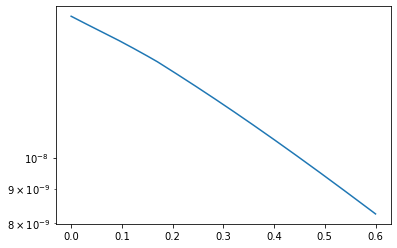

In [18]:
omb = 0.75
c = ArnaudCalculator()
c.update_mass_bias(omb)
zs_fine = np.linspace(0., 0.6, 128)
Omth_fine = np.array([c.get_Om_th(z) for z in zs_fine])
plt.plot(zs_fine, Omth_fine)
plt.yscale('log')

In [19]:
def get_relation(z):
    print(z)
    c = ArnaudCalculator()
    ombs = np.linspace(0.1, 1.2, 32)
    Omths = []
    for omb in ombs:
        c.update_mass_bias(omb)
        Omths.append(c.get_Om_th(z))
    Omths = np.array(Omths)
    return interp1d(ombs, Omths, fill_value='extrapolate', bounds_error=False)

In [20]:
rels = [get_relation(get_bin_z(i)[0]) for i in range(6)]

0.06407827174103713
0.13496553347429308
0.18685372335794864
0.2364611382540309
0.286332995683299
0.3401450561296044


In [21]:
zs = [get_bin_z(i)[0] for i in range(6)]
ws = [get_bin_z(i)[1] for i in range(6)]

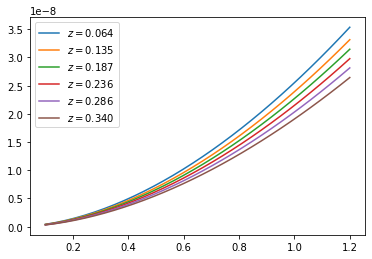

In [22]:
ombsb = np.linspace(0.1, 1.2, 32)
for z, r in zip(zs, rels):
    plt.plot(ombsb, r(ombsb), label=r'$z=%.3lf$' % z)
plt.legend(loc='upper left')

0.06407827174103713 2.0348669987802656e-08 2.6959900933405843e-09
0.13496553347429308 1.4649273203005019e-08 1.1125017931177843e-09
0.18685372335794864 1.3193611351669623e-08 8.699562621462859e-10
0.2364611382540309 1.254310183869132e-08 7.207809790797846e-10
0.286332995683299 1.1070282686116477e-08 6.563393892554307e-10
0.3401450561296044 1.2168098043684373e-08 7.272449774771281e-10


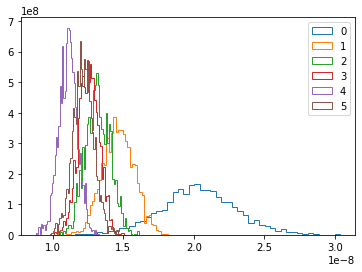

In [23]:
Omth_mean = []
Omth_std = []
for ibin in range(0, 6):
    rel = rels[ibin]
    s = gmc.loadMCSamples(f'yxg_chains/yxg_{ibin}/cobaya', settings={'ignore_rows': 0.3})
    p = s.getParams()
    Omth_chain = np.array([rel(omb) for omb in p.ygk_mass_bias])
    s.addDerived(Omth_chain, name='Omth', label='Omega_th')
    Omth_avg = np.average(Omth_chain, weights=s.weights)
    Omth_sig = np.sqrt(np.average((Omth_chain-Omth_avg)**2, weights=s.weights))
    plt.hist(Omth_chain, bins=50, weights=s.weights, label=f'{ibin}',
             density=True, histtype='step')
    print(zs[ibin], Omth_avg, Omth_sig)
    Omth_mean.append(Omth_avg)
    Omth_std.append(Omth_sig)
Omth_mean = np.array(Omth_mean)
Omth_std = np.array(Omth_std)
plt.legend()

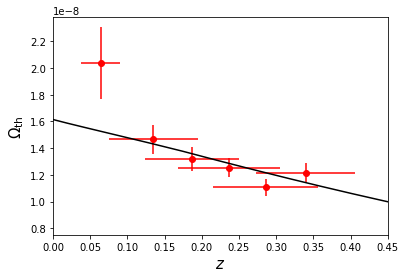

In [26]:
plt.errorbar(zs, Omth_mean, yerr=Omth_std, xerr=ws, fmt='ro')
plt.plot(zs_fine, Omth_fine, 'k-')
plt.xlabel('$z$', fontsize=15)
plt.ylabel(r'$\Omega_{\rm th}$', fontsize=15)
plt.xlim([0, 0.45])
#plt.ylim([9E-9, 1.7E-8])
plt.savefig("omth.pdf", bbox_inches='tight')
plt.show()